In [1]:
from collections import Counter
import datetime
import os
import pickle
import re
from shutil import copyfile
import tarfile
from tqdm import tqdm_notebook

import cufflinks as cf
import pandas as pd
import plotly
import numpy as np
from nltk.corpus import stopwords
import deeppavlov as dp

import gensim
from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel, TfidfModel
import pyLDAvis.gensim

cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
stopWords = set(stopwords.words('russian'))

#топ банков по активам (не нашел россельхоз банк)
bank_list = ['sberbank', 'vtb', 'gazprombank', 'vtb24', 'alfabank', 'fk_otkritie', 'mkb']
bank_info_folder = 'TopicModelingFintech'

In [2]:
def unpack_banks(folder_with_archives, bank_list):
    for bank in bank_list:
        path_to_zip_file = folder_with_archives + '/' + bank + '.tar.gz'
        if os.path.isfile(path_to_zip_file):
            if not os.path.isdir(folder_with_archives + '/' + bank):
                tar = tarfile.open(path_to_zip_file, 'r')
                tar.extractall(folder_with_archives)
                tar.close()
        else:
            print(f'{bank} not found.')


In [3]:
unpack_banks(bank_info_folder, bank_list)

In [4]:
# ! pip install deeppavlov

In [5]:
branches = pd.read_pickle('TopicModelingFintech/vtb/branches.pkl')
replies = pd.read_pickle('TopicModelingFintech/vtb/replies.pkl')
sentences_replies = pd.read_pickle('TopicModelingFintech/vtb/sentences_replies.pkl')


In [6]:
replies.head(5)

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
800,svasin_user,vtb,None,1,0,оценка: 1 проверяется,В понедельник 03.04.2017 я пришёл в Доп.офис «...,06.04.2017 17:13,Хотите просидеть в очереди час? Обратитесь в В...,1
831,MankoAnd,vtb,None,1,0,оценка: 2 проверяется,В нужный момент в ресторане золотая карта банк...,06.04.2017 12:54,"Наймите Грефа, Тинькова или других толковых ме...",2
860,tasvi777,vtb,"Добрый день, Уважаемая tasvi777! \n \nБлагод...",1,2,оценка: 1 проверяется,Являюсь клиенткой данного банка уже очень давн...,06.04.2017 7:45,Неправомерно начислены проценты по кредитной к...,1
861,Cowboy76,vtb,None,1,0,без оценки,Никому не пожелаешь оказаться на грани отчаяни...,05.04.2017 22:01,"Рефинансирование:- полшага до одобрения, руков...",-1
896,bitch123,vtb,"Добрый день, bitch123! \n \nБлагодарим Вас з...",1,1,оценка: 1 проверяется,"...Или как сделать так, чтобы из-за тысячи с п...",05.04.2017 21:45,ВТБуэ,1


In [7]:
sentences_replies.head(5)

,sentence,reply_id,deleted_extra_symbols,lemmatized,vocab_only,vw
10844,В понедельник 03.04.2017 я пришёл в Доп.офис «...,800,в понедельник я приш л в доп офис даниловский ...,в понедельник я имя л в допы офис имя втб банк...,в понедельник я имя л в допы офис имя втб банк...,"{'имя': 9, 'банк': 5, 'офис': 6, 'допы': 1, 'с..."
10845,"Пришёл я в 10.20, взял талон на погашение... в...",800,приш л я в взял талон на погашение в общем то ...,имя л я в взять талон на погашение в общий то ...,имя л я в взять талон на погашение в общий то ...,"{'имя': 3, 'обычный': 1, 'история': 4, 'талон'..."
10846,"Посмотрел, в очереди один человек, ну, думаю, ...",800,посмотрел в очереди один человек ну думаю сейч...,посмотреть в очередь один человек ну думать се...,посмотреть в очередь один человек ну думать се...,"{'платеж': 1, 'думать': 7, 'посмотреть': 9, 'с..."
10847,И совсем не угадал... куда пришёл.,800,и совсем не угадал куда приш л,и совсем не угадывать куда имя л,и совсем не угадывать куда имя л,"{'не': 1, 'угадывать': 3, 'совсем': 1, 'куда':..."
10848,Работало 3 окошка + кассы.,800,работало окошка кассы,работать окошко касса,работать окошко касса,"{'работать': 1, 'окошко': 1, 'касса': 1}"


## LDA

Модель сроится на топ-7 банков РФ по активам.

In [3]:
os.chdir('TopicModelingFintech')

In [4]:
splitted_text = {}
column_name = 'vocab_only'

for name in bank_list:
    if os.path.isdir(name):
        cur_path = os.path.join(os.getcwd(), name, 'sentences_replies.pkl')

        replies = pd.read_pickle(os.path.join(os.getcwd(), name, 'replies.pkl'))
        sentences_replies = pd.read_pickle(os.path.join(os.getcwd(), name, 'sentences_replies.pkl'))

        filtered_words = []
        for sentence in sentences_replies[column_name]:
            sentence_list = [word for word in sentence.split() if word not in stopWords]
            filtered_words.append(sentence_list)
            
        sentences_replies['filtered'] = filtered_words
        sentences_replies['filtered'] = sentences_replies['filtered'].apply(lambda x: ' '.join(x))

        replies['filtered'] = sentences_replies.groupby('reply_id').aggregate({'filtered': lambda x: ' '.join(x)})

        splitted_text[name] = replies['filtered'].apply(lambda x: str(x).split())

In [5]:
splitted_corpus = []

for value in splitted_text.values():
    splitted_corpus.extend(value)
    
len(splitted_corpus)

110590

In [6]:
id2word = gensim.corpora.Dictionary(splitted_corpus)
print(len(id2word))

stop_bank_words = ['сбербанк', 'сбер', 'втб', 'альфа', 'альфабанка','мкб', 'телебанк', 'мобайл']
id2word.filter_tokens(bad_ids=[id2word.token2id[word] for word in stop_bank_words])

id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print(len(id2word))

bow_corpus = [id2word.doc2bow(doc) for doc in splitted_corpus]

12790
12488


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, workers=3)
        model_list.append(model)

    return model_list


def compare_model_perfomance(model_list):
    perplexity = []
    c_v_coherence = []
    u_mass_coherence = []

    for model_ in model_list:
        # Compute Perplexity
        perplexity.append(model_.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

        # Compute Coherence Score c_v
        coherence_model_lda = CoherenceModel(model=model_, texts=splitted_corpus, dictionary=id2word, coherence='c_v')
        c_v_coherence.append(coherence_model_lda.get_coherence())

        # Compute Coherence Score u_mass
        coherence_model_lda = CoherenceModel(model=model_, texts=splitted_corpus, dictionary=id2word, coherence='u_mass')
        u_mass_coherence.append(coherence_model_lda.get_coherence())
        
    return perplexity, c_v_coherence, u_mass_coherence


Ниже оценена когернтность в зависимости от числа тем. Для оценки использовались метрики: Extrinsic UCI и Intrinsic UMass. 

Подробнее http://qpleple.com/topic-coherence-to-evaluate-topic-models/

Из графиков видно, что после 30 тем, когерентность UCI стабилизируется. При этом Umass и перпрелксия снижаются.

In [ ]:
limit=45; start=15; step=3;

model_list = compute_coherence_values(dictionary=id2word, corpus=bow_corpus, texts=splitted_corpus, 
                                      start=start, limit=limit, step=step)

perplexity_score, c_v_coherence, u_mass_coherence = compare_model_perfomance(model_list)

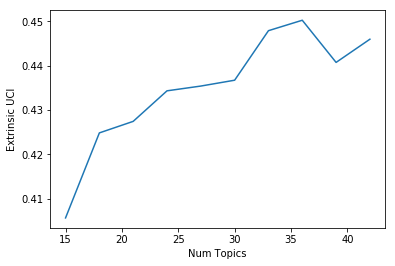

In [66]:
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, c_v_coherence)
plt.xlabel("Num Topics")
plt.ylabel("Extrinsic UCI")
plt.show()

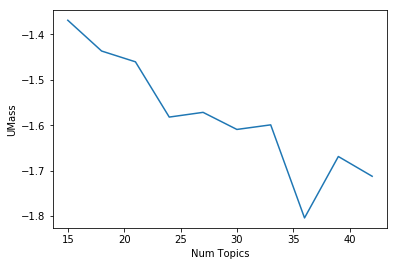

In [67]:
x = range(start, limit, step)
plt.plot(x, u_mass_coherence)
plt.xlabel("Num Topics")
plt.ylabel("UMass")
plt.show()

Приведем как выглядит LDA модель для 33 и 45 тем.

In [9]:
lda_model_33 = gensim.models.LdaMulticore(corpus=bow_corpus, id2word=id2word, num_topics=33, passes=10, workers=3)
vis_data = pyLDAvis.gensim.prepare(lda_model_33, bow_corpus, id2word)
pyLDAvis.display(vis_data)


/home/lev/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [11]:
lda_model_33.save('lda_model_33')

In [52]:
lda_model_45 = gensim.models.LdaMulticore(corpus=bow_corpus, id2word=id2word, num_topics=45, passes=10, workers=3)
vis_data = pyLDAvis.gensim.prepare(lda_model_45, bow_corpus, id2word)
pyLDAvis.display(vis_data)


## Nonnegative Matrix Factorization

В качестве альтернативы было рассмотрено матричное разложение

In [2]:
nmf_33 = Nmf(corpus=bow_corpus, num_topics=33, id2word=id2word, passes=3)

# Compute Coherence Score c_v
coherence_model_lda = CoherenceModel(model=nmf_33, texts=splitted_corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Coherence Score u_mass
coherence_model_lda = CoherenceModel(model=nmf_33, texts=splitted_corpus, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

NameError: name 'bow_corpus' is not defined

В качестве альтернативы была в матричном разложении можно использовать TF-IDF подход.

In [74]:
model = TfidfModel(bow_corpus)
cofpus_tfidf = model[bow_corpus]

In [75]:
nmf_33_tf_idf = Nmf(corpus=cofpus_tfidf, num_topics=33, id2word=id2word, passes=3)

# Compute Coherence Score c_v
coherence_model_lda = CoherenceModel(model=nmf_33_tf_idf, texts=splitted_corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Coherence Score u_mass
coherence_model_lda = CoherenceModel(model=nmf_33_tf_idf, texts=splitted_corpus, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5286640063837675

Coherence Score:  -1.9505524037719704


## Разметка тональности предложений

### Русентилекс

В качестве альтернативного подхода был использован словарь оценочный слов и словосочетаний РуСентиЛекс (http://www.labinform.ru/pub/rusentilex/index.htm)

Модель была протестирована, так как elmo модель тональности, обученная на твиттере, не очень хорошо работает на нашем корпусе. Для анализа использовались 12 тыс. самых свежих предложений из базы данных, что соотвествует примерно 800 отзывам на сайте.

In [2]:
# Загрузка Русентилекс
os.chdir('..')

read_lines = []
with open('rusentilex.txt', mode='r') as f:
    for line_num, line in enumerate(f):
        if line_num < 18:
            continue
        read_lines.append([word.strip() for word in line.split(',')[:5]])

os.chdir('TopicModelingFintech')

In [3]:
rusentilex = pd.DataFrame(read_lines, columns=['word', 'part_of_speech', 'normalized', 'sentiment', 'source'])
rusentilex.head()

,word,part_of_speech,normalized,sentiment,source
0,аборт,Noun,аборт,negative,fact
1,абортивный,Adj,абортивный,negative,fact
2,абракадабра,Noun,абракадабра,negative,opinion
3,абсурд,Noun,абсурд,negative,opinion
4,абсурдность,Noun,абсурдность,negative,opinion


In [80]:
def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

sentiment = []
for name in bank_list:
    if os.path.isdir(name):
        print(name)
        print(datetime.datetime.now())
        cur_path = os.path.join(os.getcwd(), name, 'sentences_replies.pkl')
        sentences_replies = pd.read_pickle(cur_path)
        column = 'vocab_only'
        sentiment = pd.DataFrame(sentences_replies[column])

        for tonality in ['negative', 'positive']:
            check_list = np.unique(rusentilex[rusentilex.sentiment == tonality].normalized)
            temp_list = np.zeros(len(sentiment[column]))
            for word in tqdm_notebook(check_list):
                temp_func = findWholeWord(word)
                for pos, text in enumerate(sentiment[column]):
                    if temp_func(text):
                        temp_list[pos] += 1
                
            sentiment[tonality] = temp_list
        
        sentiment.drop(column, axis=1, inplace=True)
        sentiment.to_pickle(os.path.join(os.path.join(os.getcwd(), name, name + '_sentiment.pkl')))


sberbank
2019-04-23 01:15:34.446116


KeyboardInterrupt: 

In [37]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))


def make_sentiment_zip(dest_folder):
    if not os.path.isdir(os.path.join(os.getcwd(), dest_folder)):
        os.makedirs(os.path.join(os.getcwd(), dest_folder))            
    for name in os.listdir():
        file_name = os.path.join(os.getcwd(), name, name + '_sentiment.pkl')
        if os.path.isfile(file_name):
            copyfile(file_name, os.path.join(os.getcwd(), dest_folder, name + '_sentiment.pkl'))
  
    make_tarfile(dest_folder + '.tar.gz', dest_folder)


In [39]:
make_sentiment_zip('sentilex_banki')

In [4]:
def load_data(bank_list):
    replies = {}
    sentence_replies = {}
    for name in bank_list:
        sentiment = pd.read_pickle(os.path.join(os.getcwd(), name, name + '_sentiment.pkl'))
        
        replies[name] = pd.read_pickle(os.path.join(os.getcwd(), name, 'replies.pkl'))
        
        temp_table = pd.read_pickle(os.path.join(os.getcwd(), name, 'sentences_replies.pkl'))        
        sentence_replies[name] = temp_table.merge(sentiment, left_index=True, right_index=True)

    return replies, sentence_replies

In [250]:
replies, sentence_replies = load_data(bank_list)


In [251]:
for key, item in sentence_replies.items():
    item['sum'] = item['positive'] + item['negative']
    item['diff'] = item['positive'] - item['negative']
    
    replies[key] = replies[key].loc[sentence_replies[key].reply_id.unique()]
        

### Анализ тональности отдельных предложений

Из таблицы видно, что распределение тональности предложений примерно одинаково среди банков

In [60]:
sum_table = pd.concat([table['diff'].value_counts() for table in sentence_replies.values()], axis=1)
sum_table.columns = list(sentence_replies.keys())
sum_table = sum_table / sum_table.sum(axis=0) * 100
sum_table.round(2).fillna(0)

,sberbank,vtb,gazprombank,vtb24,alfabank,fk_otkritie,mkb
-10.0,0.00,0.00,0.01,0.00,0.00,0.00,0.01
-9.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00
-8.0,0.00,0.01,0.00,0.00,0.00,0.00,0.02
-7.0,0.00,0.01,0.00,0.00,0.01,0.00,0.02
-6.0,0.01,0.01,0.00,0.01,0.03,0.02,0.02
-5.0,0.06,0.05,0.02,0.06,0.02,0.05,0.05
-4.0,0.21,0.32,0.18,0.27,0.23,0.19,0.15
-3.0,0.87,0.84,0.92,0.95,0.95,0.78,0.92
-2.0,4.21,3.99,3.78,3.92,4.03,3.92,3.68
-1.0,17.97,18.66,17.64,17.30,17.61,18.18,16.04


Распределение оценок по банкам, в % от общего числа

In [88]:
sum_table = pd.concat([table['mark'].value_counts() for table in replies.values()], axis=1)
sum_table.columns = list(replies.keys())
sum_table = sum_table / sum_table.sum(axis=0) * 100
sum_table.round(2).fillna(0)

,sberbank,vtb,gazprombank,vtb24,alfabank,fk_otkritie,mkb
-1,29.57,38.52,36.18,29.02,30.62,33.67,34.08
1,47.61,43.89,40.99,43.41,37.60,43.42,25.81
2,8.10,7.65,11.18,10.52,7.80,10.38,6.48
3,2.09,3.76,4.33,2.30,4.19,3.80,4.36
4,0.61,0.54,1.44,0.85,1.28,1.01,0.78
5,12.02,5.64,5.89,13.91,18.51,7.72,28.49


In [146]:
from ipywidgets import interact
import seaborn as sns

def print_table(mark):
    filtered_tables = []
    for key, value in replies.items():
        filtered_ids = value[value['mark'] == mark].index.unique()
        
        temp_table = sentence_replies[key]
        filtered_tables.append(temp_table[temp_table.reply_id.isin(filtered_ids)]['diff'])
    
    dummy_table = pd.Series(data = np.zeros(25), index = range(-12, 13))
    sum_table = pd.concat([dummy_table] + [table.value_counts() for table in filtered_tables], axis=1)
    sum_table.drop(columns=0, inplace=True)
    
    sum_table.columns = list(sentence_replies.keys())
    sum_table = sum_table / sum_table.sum(axis=0) * 100
    sum_table = sum_table.round(2).fillna(0)  
    cm = sns.light_palette("green", as_cmap=True)
    s = sum_table.style.background_gradient(cmap=cm)
#     s = sum_table.style.bar(subset=sum_table.columns, color='#d65f5f')

    return s

Распределение тональности по оценкам, в % от общего числа

In [148]:
interact(print_table, mark=[('Нет оценки', -1), ('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5)]);

interactive(children=(Dropdown(description='mark', options=(('Нет оценки', -1), ('1', 1), ('2', 2), ('3', 3), …

 Примеры очень положительных и очень отрицательных предложений

In [169]:
positive_sentence = []
for item in sentence_replies.values():
    positive_sentence.extend(item[item['diff'] >= 5].sentence.values)
print("Найдено предложений:", len(positive_sentence))
print()

for text in positive_sentence[0:80:8]:
    print(text)
    print()

Найдено предложений: 80

Хочу особенно отметить его высокий профессионализм, оперативность, ответственность, отличное знание предмета и очень корректное, доброжелательное отношение.

На протяжении всего рассмотрения моего дела я получал неограниченное внимание, профессиональные консультации и неравнодушную человеческую поддержку со стороны Яны Арутюнян.

Очень внимательная, спокойная, добрая, отзывчивая и отличный специалист в своей работе.

Выражаю глубокую благодарность и признательность за чуткость, внимательность и предельную вежливость сотрудника Банка Москвы, отделение Марьинское, специалисту Сейд-Гусейнову Шамилю Османовичу!

Очень просторный, чистый зал, менеджеры все приветливы, заняты клиентами, что у меня вызвало очень приятные и доверительные чувства.

Через пару дней я приехал в офис для встречи со своим персональным менеджером, на входе меня встретил улыбчивый администратор, проводила в зону обслуживания клиентов Привилегии (а это целый этаж), присев в комфортной перегово

In [168]:
negative_sentence = []
for item in sentence_replies.values():
    negative_sentence.extend(item[item['diff'] <= -5].sentence.values)
print("Найдено предложений:", len(negative_sentence))
print()

for text in negative_sentence[0:80:8]:
    print(text)
    print()


Найдено предложений: 60

я буду вынуждена обратиться во все инстанции с жалобами на действия Сбербанка, точнее, конкретно Вашего отделения, на поведение Ваших сотрудников, в действиях которых предусматривается состав преступления, предусмотренного статьей 159 УК РФ «Мошенничество» - причем, кроме хищения чужого имущества или приобретения права на чужое имущество путем обмана или злоупотребления доверием в данной ситуации просматривается мошенничество, совершенное лицом с использованием своего служебного положения, а равно в крупном размере, а возможно и мошенничество, совершенное группой лиц по предварительному сговору, а равно с причинением значительного ущерба гражданину.

Пункты 2.1.1 и 3.20 Правил комплексного   банковского обслуживания ВТБ(ПАО нарушают права потребителя финансовых   услуг и противоречат Гражданскому Кодексу РФ, Ст 858 Гражданского Кодекса РФ ,   ограничение прав клиента на распоряжение денежными средствами,   находящимися на счете, не допускается, за исключением н

In [184]:
neutral_sentence = []
for item in sentence_replies.values():
    neutral_sentence.extend(item[item['sum'] <= 2].sentence.values)
print("Найдено предложений:", len(neutral_sentence))
print()

for text in neutral_sentence[0:100:10]:
    print(text)
    print()


Найдено предложений: 77837

Снимал деньги в банкомате  20.03.2017        в метро на пл.

в банкомат, но зачислена она не была.

При обращении в банк, сотрудники отказываются со мной разговаривать, дверь закрыта, говорят через домофон, что общаться не будут, т.к.

Зорге, 37, уточнив у сотрудника на входе, кто из специалистов может помочь в моем вопросе, отстояв очередь в течении 15 минут попала к специалисту Волковой Анне.

Сотрудница предложила подать на рефинансирование,погасить долг в втб,плюс взять сумму которая нам нужна.Мы согласились и ушли подготавливать документы.

После изучения договора страхования я обратилась в это отделения сбербанка с просьбой написать заявление для отказа от программы страхования.

На что им была переслана копия заявления, где реквизиты были правильные...   Дальше сумму всё-таки перевели, но с опозданием в несколько дней.

В итоге выдали неименованую.

Я тогда не особо расстроился, подумав: "Ну раз не нужны Сберу клиенты, буду работать с другим банком".


Примеры предложений, в которых много тональных слов, но общая тональность неясна.

In [189]:
negative_sentence = []
for item in sentence_replies.values():
    negative_sentence.extend(item[(item['sum'] > 6) & (abs(item['diff']) < 2)].sentence.values)
print("Найдено предложений:", len(negative_sentence))
print()

for text in negative_sentence[1:100:10]:
    print(text)
    print()


Найдено предложений: 50

Если у клиента банка решен вопрос с пенсионными накоплениями и его не интересуют страховки жизни и имущества то - внимательный, оперативный и очень чуткий банк все равно напомнит о себе и предложит эти пресловутые продукты при каждом удобном и не очень случае, но если у клиента банка действительно возникают проблемы, по имеющимся продуктам или оказываемым услугам или нужны конкретные компетентные пояснения, все резко меняется в обратном направлении.

Никого, конечно, не обвиняю: банк - потому, что пианист играет, как умеет; работника - потому, что кто-то должен издавать звуки игры; себя - потому, что, во-первых, цена выгоды была ниже среднего, а во-вторых, свою рассеянность рассматриваю как напоминание о важности вопроса неизбежной старости и необходимости передачи своим спиногрызам своих знаний и ответственности прежде, чем я выжил из ума; а слякоть ни при чём - потому что СПб.

После инцидента в Сбербанке, вип клиентом которого являлись, со снятием судебными 

### Анализ тональности отзывов

In [252]:
for key in replies.keys():
    replies[key] = replies[key].merge(sentence_replies[key].groupby('reply_id').agg({'positive': sum, 'negative': sum, 'diff': np.mean}), 
                                      left_index=True, right_index=True)
    replies[key]['diff_abs'] = replies[key]['positive'] - replies[key]['negative']

In [253]:
replies['vtb']

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark,positive,negative,diff,diff_abs
800,svasin_user,vtb,None,1,0,оценка: 1 проверяется,В понедельник 03.04.2017 я пришёл в Доп.офис «...,06.04.2017 17:13,Хотите просидеть в очереди час? Обратитесь в В...,1,4.0,17.0,-0.481481,-13.0
831,MankoAnd,vtb,None,1,0,оценка: 2 проверяется,В нужный момент в ресторане золотая карта банк...,06.04.2017 12:54,"Наймите Грефа, Тинькова или других толковых ме...",2,6.0,23.0,-0.361702,-17.0
860,tasvi777,vtb,"Добрый день, Уважаемая tasvi777! \n \nБлагод...",1,2,оценка: 1 проверяется,Являюсь клиенткой данного банка уже очень давн...,06.04.2017 7:45,Неправомерно начислены проценты по кредитной к...,1,8.0,9.0,-0.090909,-1.0
861,Cowboy76,vtb,None,1,0,без оценки,Никому не пожелаешь оказаться на грани отчаяни...,05.04.2017 22:01,"Рефинансирование:- полшага до одобрения, руков...",-1,32.0,29.0,0.055556,3.0
896,bitch123,vtb,"Добрый день, bitch123! \n \nБлагодарим Вас з...",1,1,оценка: 1 проверяется,"...Или как сделать так, чтобы из-за тысячи с п...",05.04.2017 21:45,ВТБуэ,1,6.0,12.0,-0.187500,-6.0
897,6085323,vtb,"Добрый день, Уважаемый 6085323! \n \nБлагода...",1,1,оценка: 1 проверяется,Все началось с исчезновения карты в Онлайн бан...,05.04.2017 20:46,С 01 марта 2017 года пытаюсь добиться от Банка...,1,15.0,13.0,0.074074,2.0
932,banderezzz,vtb,"Добрый день, Уважаемый banderezzz! \n \nБлаг...",1,0,оценка: 1 проверяется,"Все началось с того, что последний месяц кажды...",05.04.2017 17:32,Обман,1,2.0,1.0,0.076923,1.0
933,kostya92msk,vtb,"Добрый день, Уважаемый kostya92msk! \n \nБла...",1,0,оценка: 1 проверяется,Имея карту S7-Банк Москвы сделал бронирование ...,05.04.2017 16:53,Не поятные конвертации,1,1.0,1.0,0.000000,0.0
971,nikel_banki,vtb,None,1,0,оценка: 1 проверяется,Поразительно плохие информационные сервисы: ...,05.04.2017 14:30,Мобильный банк,1,3.0,14.0,-0.611111,-11.0
972,rindex,vtb,"Добрый день, Уважаемый rindex! \n \nБлагодар...",1,0,оценка: 3 проверяется,Стал клиентом БМ в конце марта. Банк предложил...,04.04.2017 23:57,"Страховка? Нет, сертификаты на адвокатов",3,6.0,3.0,0.176471,3.0


In [246]:
def print_replies_table(field):
    filtered_tables = []
    for key, value in replies.items():
#         return value.groupby('mark').agg({'negative': np.mean})
                                         
        filtered_tables.append(value.groupby('mark').agg({field: np.mean}))
    
#     dummy_table = pd.Series(data = np.zeros(25), index = range(-12, 13))
    sum_table = pd.concat([table for table in filtered_tables], axis=1)
    
    sum_table.columns = list(sentence_replies.keys())
#     sum_table = sum_table / sum_table.sum(axis=0) * 100
    sum_table = sum_table.round(2).fillna(0)  
    cm = sns.light_palette("green", as_cmap=True)
    s = sum_table.style.background_gradient(cmap=cm)
#     s = sum_table.style.bar(subset=sum_table.columns, color='#d65f5f')

    return s

In [247]:
print_replies_table('negative')

,sberbank,vtb,gazprombank,vtb24,alfabank,fk_otkritie,mkb
mark,,,,,,,
-1,5.77,6.57,5.38,5.82,6.38,6.07,6.14
1,7.72,7.28,6.46,8,8.05,7.68,7.24
2,5.52,8.32,6.88,6.75,6.22,6.7,6.36
3,10.24,7.54,6.22,5.05,5.14,4,8.62
4,6.2,6,6.75,4.71,6.64,4,5.14
5,2.43,3.29,2.49,2.9,2.08,2.48,1.9


In [248]:
print_replies_table('positive')

,sberbank,vtb,gazprombank,vtb24,alfabank,fk_otkritie,mkb
mark,,,,,,,
-1,4.61,4.78,4.31,4.94,5.06,4.76,5.59
1,5.24,5.39,4.49,6.35,5.47,5.59,5.69
2,4.23,6.14,5.12,5.91,5.6,5.28,5.48
3,6.65,6.25,6.19,5.37,5.06,5.17,6.15
4,4.2,4.5,9.17,3.29,5.73,4.25,6.43
5,7.19,7.5,7.22,8.58,6.68,6.92,6.91


In [249]:
print_replies_table('diff')

,sberbank,vtb,gazprombank,vtb24,alfabank,fk_otkritie,mkb
mark,,,,,,,
-1,-0.1,-0.13,-0.08,-0.05,-0.09,-0.07,-0.04
1,-0.18,-0.12,-0.13,-0.13,-0.18,-0.14,-0.12
2,-0.11,-0.11,-0.15,-0.07,-0.06,-0.12,-0.06
3,-0.2,-0.02,-0.01,-0.04,0.03,0.11,-0.15
4,-0.13,-0.14,0.27,-0.15,-0.08,0,0.19
5,0.84,0.66,0.57,0.73,0.72,0.69,0.81


In [254]:
print_replies_table('diff_abs')

,sberbank,vtb,gazprombank,vtb24,alfabank,fk_otkritie,mkb
mark,,,,,,,
-1,-1.16,-1.79,-1.07,-0.88,-1.32,-1.31,-0.55
1,-2.48,-1.88,-1.97,-1.65,-2.58,-2.1,-1.55
2,-1.29,-2.18,-1.76,-0.84,-0.63,-1.41,-0.88
3,-3.59,-1.29,-0.03,0.32,-0.08,1.17,-2.46
4,-2,-1.5,2.42,-1.43,-0.91,0.25,1.29
5,4.77,4.21,4.73,5.68,4.6,4.44,5


Разобъем оценки по негативных доле числа негативных отзывов

### Deeppavlov

In [9]:
for name in bank_list:
    if os.path.isdir(name):
        print(name)
        print(datetime.datetime.now())
        cur_path = os.path.join(os.getcwd(), name, 'sentences_replies.pkl')
        sentences_replies = pd.read_pickle(cur_path)
        column = 'vocab_only'
        sentiment = pd.DataFrame(sentences_replies[column][:12_000])

        temp_list = []
        for i in range(0, len(sentiment), 100):
            if i % 2000 == 0:
                print(i)
            temp_list_batch = elmo(sentiment[column][i:i + 100])
            temp_list.extend(temp_list_batch)
            
        sentiment['sentiment'] = [x[0] for x in temp_list]
        sentiment.drop(column, axis=1, inplace=True)
        sentiment.to_pickle(os.path.join(os.path.join(os.getcwd(), name, name + '_sentiment.pkl')))


sberbank
2019-04-21 00:09:26.945907
0
2000
4000
6000
8000
10000
vtb
2019-04-21 00:10:04.168915
0
2000
4000
6000
8000
10000
gazprombank
2019-04-21 00:10:19.007287
0
2000
4000
6000
8000
10000
vtb24
2019-04-21 00:10:31.526661
0
2000
4000
6000
8000
10000
alfabank
2019-04-21 00:11:00.355440
0
2000
4000
6000
8000
10000
fk_otkritie
2019-04-21 00:11:25.666018
0
2000
4000
6000
8000
10000
mkb
2019-04-21 00:11:40.223567
0
2000
4000
6000
8000
10000
